# Education Data Analysis - Gender in Month vs Grades

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [25]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=14286893056, percent=58.4, used=18306772992, free=150335488, active=14140071936, inactive=14128439296, wired=4166701056)


In [ ]:
import csv
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress 
import matplotlib as mpl
from matplotlib import gridspec
from PIL import Image

In [27]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [28]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [29]:
# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


0

In [30]:
def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols

# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [33]:
# Import plot style
plt.style.use("birthmonth.mplstyle")

In [34]:
# ========== PRIMARY-SECONDARY WITH GENDER COLOR PALETTE ==========
palette_gender = {
    'primary': {
        'male': {
            # cooler blue
            'points': '#235B9F',           # deep blue
            'thermalized_band': '#8FBEEA', # light blue band
            'thermalized_mean_line': '#0072B2',  # mid-blue line
        },
        'female': {
            # greener / teal to contrast male blue
            'points': '#1B8C5A',           # deep teal-green
            'thermalized_band': '#8FD6B5', # light mint band
            'thermalized_mean_line': '#00A676',  # vivid teal line
        },
    },
    'secondary': {
        'male': {
            # keep in cool violet direction
            'points': '#5A2D91',           # violet / indigo
            'thermalized_band': '#C9B4F5', # pale lavender band
            'thermalized_mean_line': '#7B3FB4',  # bright violet line
        },
        'female': {
            # move clearly toward orange‑chocolate
            'points': '#C15A21',           # burnt orange
            'thermalized_band': '#F4C49B', # light peach band
            'thermalized_mean_line': '#8C3A13',  # chocolate‑orange line
        },
    },
}

In [35]:
# Create plot directories:
# Base directory: one level above current
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Root folder for these figures
birth_root = os.path.join(base_dir, "BirthMonth-Plots")

# Main subfolders
birth_dir_nogender = os.path.join(birth_root, "No-gender")
birth_dir_gender = os.path.join(birth_root, "Gender")

# New subfolders inside No-gender
birth_dir_gender_primary = os.path.join(birth_dir_gender, "Primary")
birth_dir_gender_secondary = os.path.join(birth_dir_gender, "Secondary")

# Create all folders if they do not exist
os.makedirs(birth_dir_gender_primary, exist_ok=True)
os.makedirs(birth_dir_gender_secondary, exist_ok=True)
os.makedirs(birth_dir_gender, exist_ok=True)

## 1. Initial plots

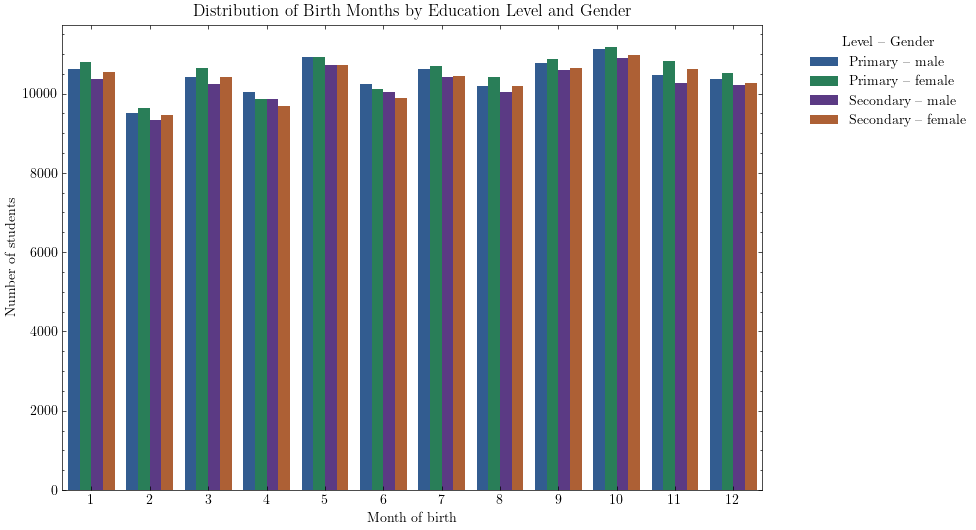

In [ ]:
plt.style.use("birthmonth.mplstyle")

# ===============================
# Plot 1 (gender): Birth months by level & gender (single plot)
# ===============================

# Unique students with month of birth and gender for each level
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting
df_birth = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order months 1..12
df_birth['MES_NAIXEMENT'] = pd.Categorical(
    df_birth['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Map numeric/letter gender codes to 'male'/'female'
gender_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}
df_birth['gender_key'] = df_birth['GENERE'].map(gender_map)

# Drop any rows with unmapped gender
df_birth = df_birth.dropna(subset=['gender_key'])

# Create combined level+gender category: e.g. "Primary – male", "Secondary – female"
df_birth['level_gender'] = (
    df_birth['snapshot'].astype(str) + ' – ' + df_birth['gender_key'].astype(str)
)

# Build a palette dict for the hue levels using palette_gender['...']['...']['points']
level_gender_palette = {
    'Primary – male':     palette_gender['primary']['male']['points'],
    'Primary – female':   palette_gender['primary']['female']['points'],
    'Secondary – male':   palette_gender['secondary']['male']['points'],
    'Secondary – female': palette_gender['secondary']['female']['points'],
}

# Define hue order so bar groups are consistent across months
hue_order = [
    'Primary – male',
    'Primary – female',
    'Secondary – male',
    'Secondary – female'
]

plt.figure(figsize=(10, 5.5))
sns.countplot(
    data=df_birth,
    x='MES_NAIXEMENT',
    hue='level_gender',
    hue_order=hue_order,
    palette=level_gender_palette  # dict mapping hue level -> color
) 

plt.title('Distribution of Birth Months by Education Level and Gender')
plt.xlabel('Month of birth')
plt.ylabel('Number of students')
plt.legend(title='Level – Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='x', which='minor', length=0)

filename = "1.birth_month_distribution_gender_primary_secondary.png"
plt.savefig(os.path.join(birth_dir_gender, filename), dpi=900, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [37]:
plt.style.use("birthmonth.mplstyle")

# ===============================
# CATALAN DISTRIBUTIONS BY GENDER AND LEVEL
# ===============================

# Map raw GENERE codes to 'male'/'female'
gender_key_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}

# Primary with gender
df_cat_P = (
    df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT', 'GENERE']]
    .drop_duplicates('CODI_ALUMNE')
    .copy()
)
df_cat_P['gender'] = df_cat_P['GENERE'].map(gender_key_map)
df_cat_P = df_cat_P[df_cat_P['gender'].isin(['male', 'female'])]

df_cat_P['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_P['MES_NAIXEMENT'].astype(str),
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_P['snapshot'] = 'Primary'

# Secondary with gender
df_cat_S = (
    df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT', 'GENERE']]
    .drop_duplicates('CODI_ALUMNE')
    .copy()
)
df_cat_S['gender'] = df_cat_S['GENERE'].map(gender_key_map)
df_cat_S = df_cat_S[df_cat_S['gender'].isin(['male', 'female'])]

df_cat_S['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_S['MES_NAIXEMENT'].astype(str),
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_S['snapshot'] = 'Secondary'

# Combine
df_cat_grades = pd.concat([df_cat_P, df_cat_S], ignore_index=True)

df_cat_grades['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_grades['MES_NAIXEMENT'].astype(str),
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)


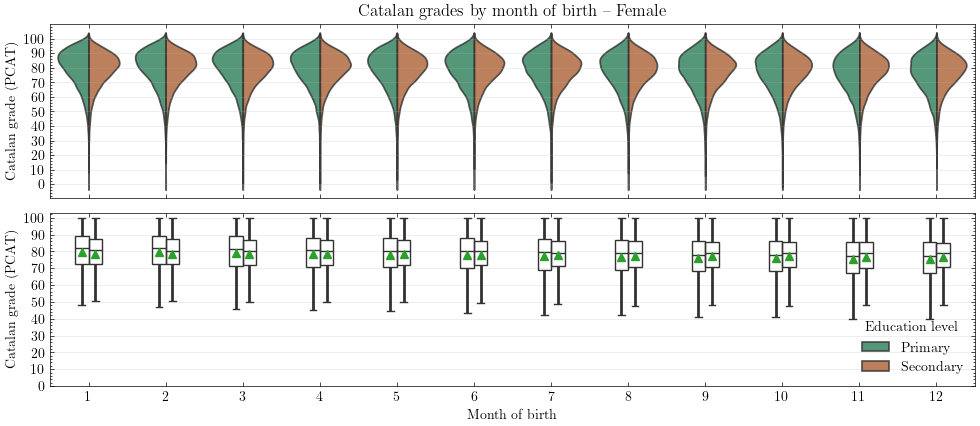

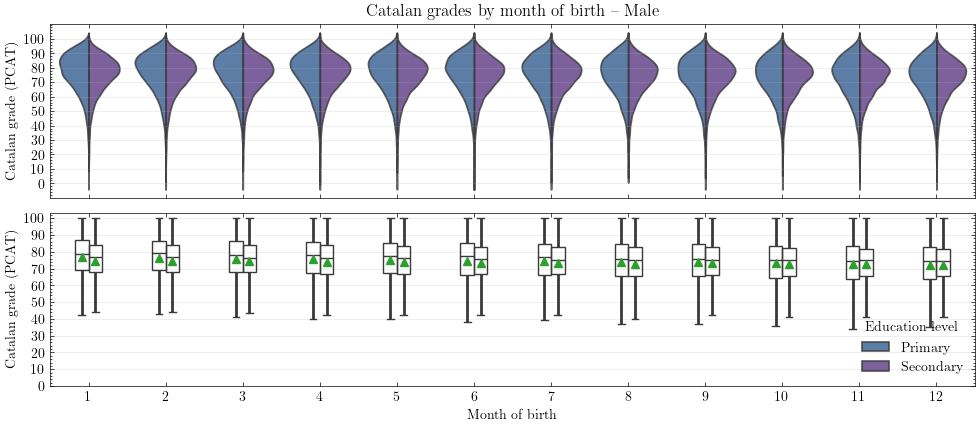

In [38]:
# ===============================
# Multiplot by gender
# ===============================
hue_order_level = ['Primary', 'Secondary']
genders = ['female', 'male']
titles  = {'female': 'Female', 'male': 'Male'}

for g in genders:
    # Palette depends on normalized gender g
    cat_palette = {
        'Primary':   palette_gender['primary'][g]['points'],
        'Secondary': palette_gender['secondary'][g]['points'],
    }

    df_g = df_cat_grades[df_cat_grades['gender'] == g].copy()

    if df_g.empty:
        continue  # nothing to plot for this gender

    fig, (ax_violin, ax_box) = plt.subplots(
        2, 1,
        figsize=(10, 7),
        sharex=True
    )

    # --- Top: violin distributions ---
    sns.violinplot(
        data=df_g,
        x='MES_NAIXEMENT',
        y='PCAT',
        hue='snapshot',
        hue_order=hue_order_level,
        palette=cat_palette,
        alpha=0.8,
        split=True,
        inner=None,
        ax=ax_violin
    )

    ax_violin.set_ylabel('Catalan grade (PCAT)')
    ax_violin.set_title(f'Catalan grades by month of birth – {titles[g]}')

    # --- Bottom: boxplots only ---
    sns.boxplot(
        data=df_g,
        x='MES_NAIXEMENT',
        y='PCAT',
        hue='snapshot',
        hue_order=hue_order_level,
        showcaps=True,
        boxprops={'facecolor': 'none', 'zorder': 3},
        showfliers=False,
        whiskerprops={'linewidth': 2},
        width=0.35,
        palette=cat_palette,
        ax=ax_box,
        showmeans=True,
        meanprops={'label': 'mean'}
    )

    ax_box.set_ylabel('Catalan grade (PCAT)')
    ax_box.set_xlabel('Month of birth')

    ax_violin.set_yticks(range(0, 101, 10))
    ax_box.set_yticks(range(0, 101, 10))

    for ax in (ax_violin, ax_box):
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', which='minor', length=0)

    plt.tight_layout()

    # Legend: take handles/labels from top axis only
    handles, labels = ax_violin.get_legend_handles_labels()
    if ax_violin.legend_ is not None:
        ax_violin.legend_.remove()

    ax_box.legend(
        handles[:2], labels[:2],
        title='Education level',
        loc='lower right'
    )

    os.makedirs(birth_dir_gender, exist_ok=True)
    filename = f"2.violin_box_multiplot_catalan_primary_secondary_{g}.png"
    fig.savefig(os.path.join(birth_dir_gender, filename), dpi=600, bbox_inches='tight')

    plt.show()


## 2. Generalized analysis of the means

In [39]:
# MAIN SUBJECTS:
subjects = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN', 'PMED']

subjects_P = [s for s in subjects if s in df_P.columns]
subjects_S = [s for s in subjects if s in df_S.columns]

print("Primary subjects:", subjects_P)
print("Secondary subjects:", subjects_S)


Primary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
Secondary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']


### Calculations

#### Implement a randomization of primary and secondary data. Add statistics

In [40]:
# --------------------------------------------------------
# 1. Thermalize one subject 
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
              already filtered to the subgroup (e.g. Primary + girls).
    grade_col: name of the grade column (string).

    Returns
    -------
    summary : DataFrame with month-level stats (months 1..12):
        month
        real_mean, real_std, real_n, real_sem
        null_mean, null_std, null_median
        q1, q3, iqr
        z_score, z_iqr
        band_min, band_max
        band_p16, band_p84
        band_p2_5, band_p97_5

    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df[grade_col] = pd.to_numeric(df[grade_col], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # --- Real stats per month (for error bars) ---
    real_grp = df.groupby('MES_NAIXEMENT')[grade_col]

    real_means = (
        real_grp.mean()
        .reindex(months, fill_value=np.nan)
    )
    real_std = (
        real_grp.std(ddof=1)      # sample SD of grades
        .reindex(months, fill_value=np.nan)
    )
    real_n = (
        real_grp.size()
        .reindex(months, fill_value=0)
        .astype(int)
    )

    # Standard error of the mean
    real_sem = real_std / np.sqrt(real_n.replace(0, np.nan))

    real_mean = real_means.values

    # --- Null distribution via month randomization ---
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # --- Null summaries ---
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-scores
    z     = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Full envelope
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    # ~68% central band
    band_p16, band_p84 = np.nanpercentile(sim, [16, 84], axis=0)

    # ~95% central band
    band_p2_5, band_p97_5 = np.nanpercentile(sim, [2.5, 97.5], axis=0)

    summary = pd.DataFrame({
        'month':     months,
        'real_mean': real_mean,
        'real_std':  real_std.values,
        'real_n':    real_n.values,
        'real_sem':  real_sem.values,
        'null_mean': null_mean,
        'null_std':  null_std,
        'null_median': null_med,
        'q1':        q1,
        'q3':        q3,
        'iqr':       iqr,
        'z_score':   z,
        'z_iqr':     z_iqr,
        'band_min':  band_min,
        'band_max':  band_max,
        'band_p16':  band_p16,
        'band_p84':  band_p84,
        'band_p2_5': band_p2_5,
        'band_p97_5': band_p97_5
    })

    return summary, sim


In [41]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# Distinct gender codes present in Primary
genders_P = sorted(df_P['GENERE'].dropna().unique())

# Map raw GENERE codes to 'male'/'female'
gender_key_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
primary_summaries_gender = {}   # dict: (subj, raw_gender_code) -> summary DataFrame
primary_sims_gender = {}        # dict: (subj, raw_gender_code) -> sim array
all_summaries = []

for subj in subjects_P:
    # Base dataframe for this subject in Primary
    base_df = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_P:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        # Map to 'male'/'female'; skip unknown codes
        gender_key = gender_key_map.get(gen, None)
        if gender_key not in ('male', 'female'):
            continue

        summary_P, sim_P = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_P['subject'] = subj
        summary_P['snapshot'] = 'Primary'
        summary_P['gender'] = gender_key   # normalized label

        primary_summaries_gender[(subj, gen)] = summary_P
        primary_sims_gender[(subj, gen)] = sim_P
        all_summaries.append(summary_P)

# Long-format dataset with all Primary stats by gender
# (includes real_sem, bands, z_score, z_iqr, etc. from thermalize_subject_by_month)
df_stats_primary_gender_all = pd.concat(all_summaries, ignore_index=True)


In [42]:
# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# Distinct gender codes present in Secondary
genders_S = sorted(df_S['GENERE'].dropna().unique())

# Map raw GENERE codes to 'male'/'female'
gender_key_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
secondary_summaries_gender = {}   # dict: (subj, raw_gender_code) -> summary DataFrame
secondary_sims_gender = {}        # dict: (subj, raw_gender_code) -> sim array
all_summaries = []

for subj in subjects_S:
    # Base dataframe for this subject in Secondary
    base_df = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_S:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        # Map to 'male'/'female'; skip unknown codes
        gender_key = gender_key_map.get(gen, None)
        if gender_key not in ('male', 'female'):
            continue

        summary_S, sim_S = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_S['subject'] = subj
        summary_S['snapshot'] = 'Secondary'
        summary_S['gender'] = gender_key   # normalized label

        secondary_summaries_gender[(subj, gen)] = summary_S
        secondary_sims_gender[(subj, gen)] = sim_S
        all_summaries.append(summary_S)

# Long-format dataset with all Secondary stats by gender
# (includes real_sem, band_p16/84, band_p2_5/97_5, z_score, z_iqr, etc.)
df_stats_secondary_gender_all = pd.concat(all_summaries, ignore_index=True) 


### Plots

#### Primary plots + Gender

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2659314044.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


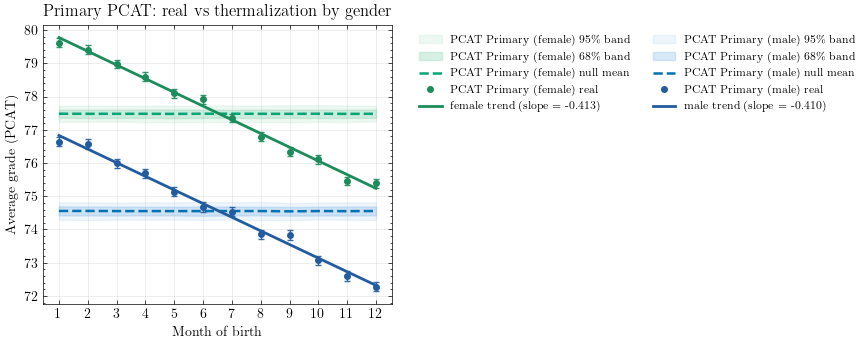

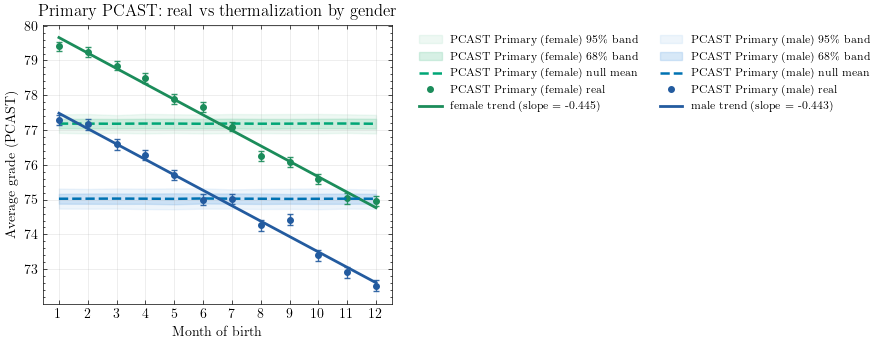

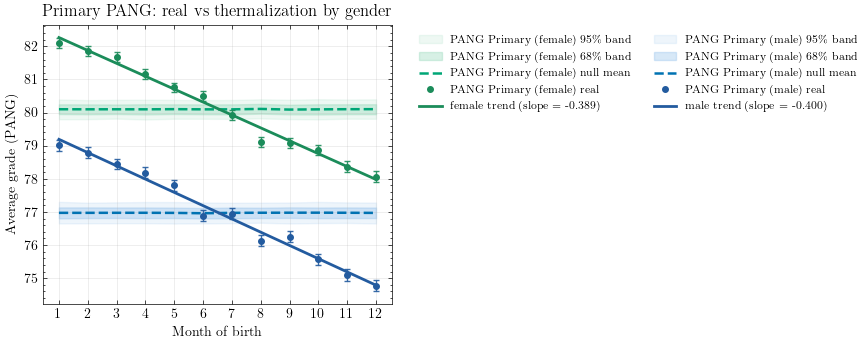

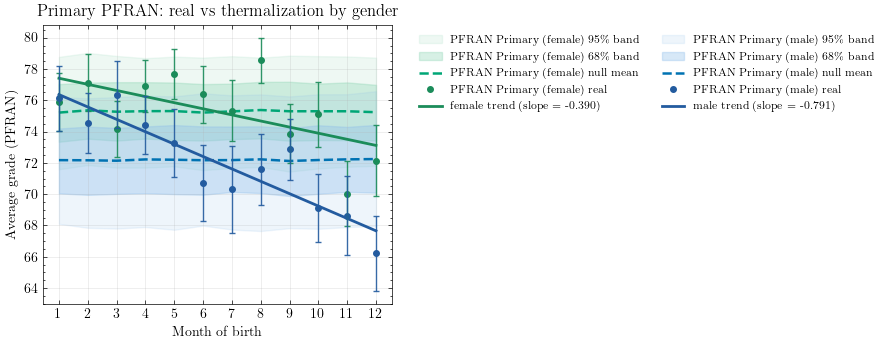

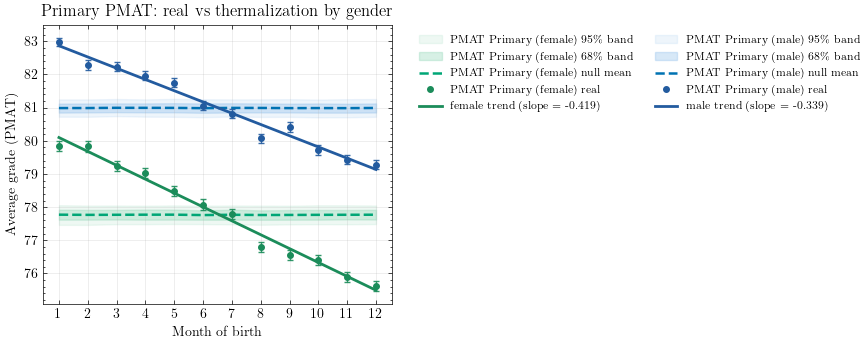

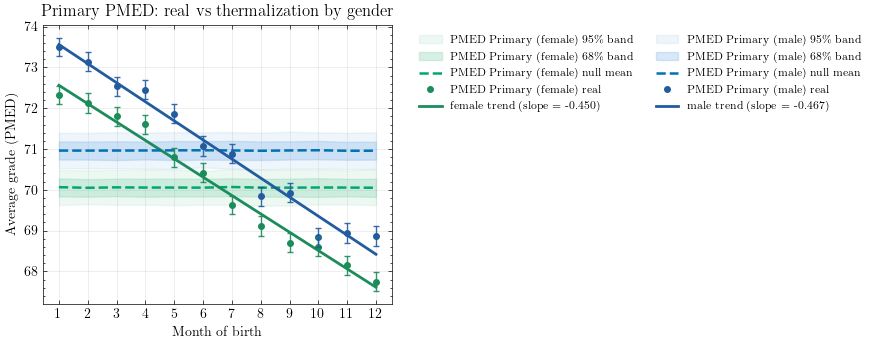

In [ ]:
plt.style.use("birthmonth.mplstyle")

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary, by gender)
# --------------------------------------------------------
os.makedirs(birth_dir_gender_primary, exist_ok=True)

for subj in subjects_P:
    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    for gen in genders_P:
        key = (subj, gen)
        if key not in primary_summaries_gender:
            continue  # no data for this subject+gender

        summary_P = primary_summaries_gender[key]

        # Use normalized gender label from the summary
        gender_key = summary_P['gender'].iloc[0]  # 'male' or 'female'

        months     = summary_P['month'].values
        real_mean  = summary_P['real_mean'].values
        real_std   = summary_P['real_std'].values   # spread of grades per gender
        band_mean  = summary_P['null_mean'].values
        band_p16   = summary_P['band_p16'].values
        band_p84   = summary_P['band_p84'].values
        band_p2_5  = summary_P['band_p2_5'].values
        band_p97_5 = summary_P['band_p97_5'].values

        # Colors from gender palette (PRIMARY)
        band_color  = palette_gender['primary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['primary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['primary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15,
            label=f'{subj} Primary ({gender_key}) 95\% band'
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35,
            label=f'{subj} Primary ({gender_key}) 68\% band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--', linewidth=1.8,
            color=mean_color,
            marker=None,
            label=f'{subj} Primary ({gender_key}) null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            label=f'{subj} Primary ({gender_key}) real'
        )
        
        real_sem = real_std / np.sqrt(summary_P['real_n'].values)
        # Error bars on real means: +- standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=f'{gender_key} trend (slope = {slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"primary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(birth_dir_gender_primary, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


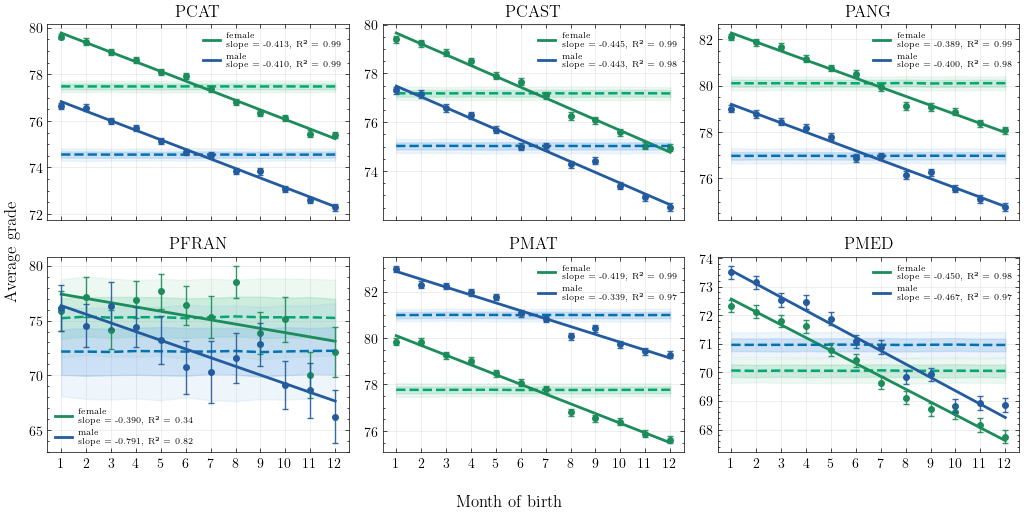

In [44]:
plt.style.use("birthmonth.mplstyle")

#--------------------------
#   PRIMARY – MULTIPLOT BY GENDER
#--------------------------

os.makedirs(birth_dir_gender_primary, exist_ok=True)

subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']

n_subj = len(subjects_P)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True,    # same month axis
    sharey=False    # each subject chooses its own y-range
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_P):
    # We will accumulate handles/labels per subject for a single legend
    for gen in genders_P:
        key = (subj, gen)
        if key not in primary_summaries_gender:
            continue  # no data for this subject+gender

        summary_P = primary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_P['gender'].iloc[0]

        months     = summary_P['month'].values
        real_mean  = summary_P['real_mean'].values
        real_std   = summary_P['real_std'].values
        real_n     = summary_P['real_n'].values
        band_mean  = summary_P['null_mean'].values
        band_p16   = summary_P['band_p16'].values
        band_p84   = summary_P['band_p84'].values
        band_p2_5  = summary_P['band_p2_5'].values
        band_p97_5 = summary_P['band_p97_5'].values

        # Colors from gender palette (PRIMARY)
        band_color  = palette_gender['primary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['primary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['primary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35
        )

        # Thermalized mean line (null mean) for this gender
        ax.plot(
            months, band_mean,
            linestyle='--',
            linewidth=1.8,
            color=mean_color,
            marker=None,
            #label=f'{gender_key} null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            #label=f'{gender_key} real mean'
        )

        # SEM from SD and n
        real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # Linear regression on real means, with slope and R^2 in legend text
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months
            r2 = r**2

            trend_label = f'{gender_key}\n slope = {slope:.3f}, R² = {r2:.2f}'

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=trend_label
            )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

    # One legend per subject (if something was plotted)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=6, loc='best')

# Hide unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

# Remove minor x ticks
for ax in fig.axes:
    ax.tick_params(axis='x', which='minor', length=0)

fig.tight_layout()
fig.savefig(
    os.path.join(birth_dir_gender_primary, "all_primary_subjects_by_gender_multiplot.png"),
    dpi=600,
    bbox_inches='tight'
)
plt.show()


#### Secondary plots + Gender

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2045675772.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


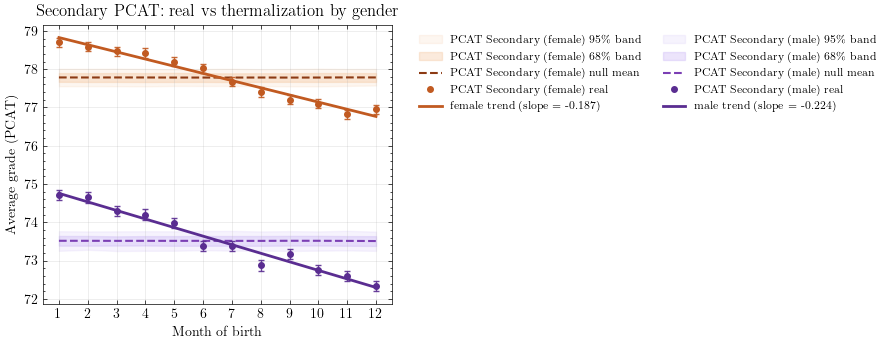

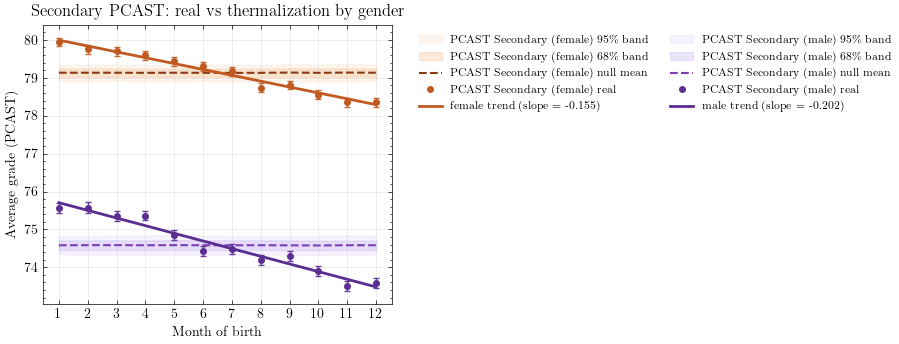

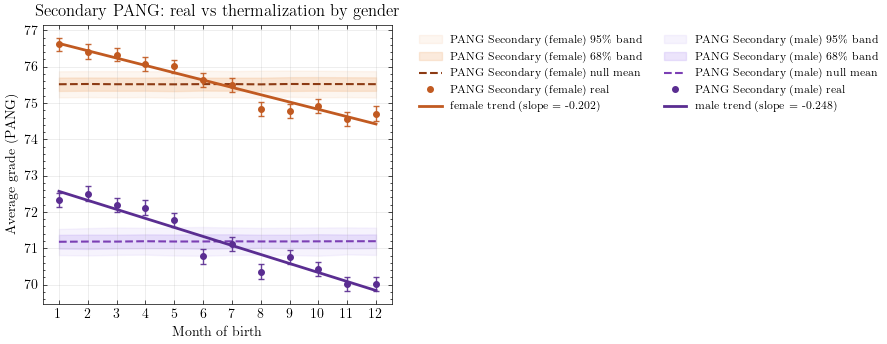

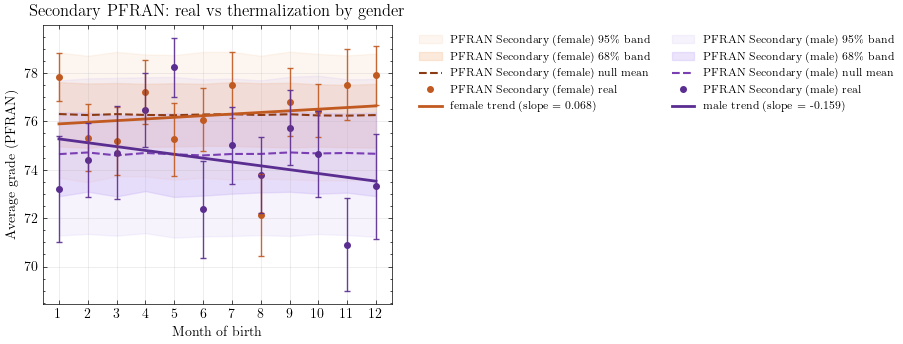

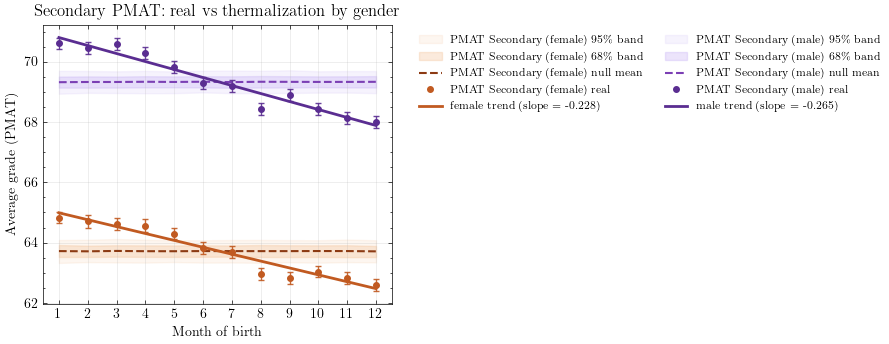

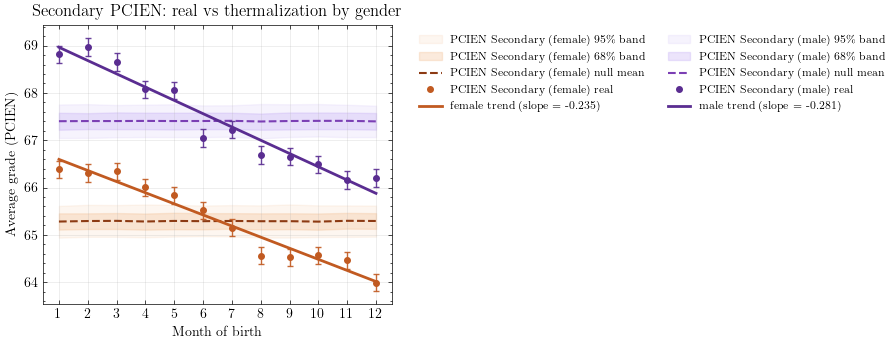

In [ ]:
plt.style.use("birthmonth.mplstyle")

# --------------------------------------------------------
# Plot and save all subjects (Secondary, by gender)
# --------------------------------------------------------

os.makedirs(birth_dir_gender_secondary, exist_ok=True)

for subj in subjects_S:
    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    for gen in genders_S:
        key = (subj, gen)
        if key not in secondary_summaries_gender:
            continue  # no data for this subject+gender

        summary_S = secondary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_S['gender'].iloc[0]

        months     = summary_S['month'].values
        real_mean  = summary_S['real_mean'].values
        real_std   = summary_S['real_std'].values     # <-- spread of grades
        band_mean  = summary_S['null_mean'].values
        band_p16   = summary_S['band_p16'].values
        band_p84   = summary_S['band_p84'].values
        band_p2_5  = summary_S['band_p2_5'].values
        band_p97_5 = summary_S['band_p97_5'].values

        # Colors from gender palette (SECONDARY)
        band_color  = palette_gender['secondary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['secondary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['secondary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15,
            label=f'{subj} Secondary ({gender_key}) 95\% band'
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35,
            label=f'{subj} Secondary ({gender_key}) 68\% band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--',
            linewidth=1.5,
            color=mean_color,
            marker=None,
            label=f'{subj} Secondary ({gender_key}) null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            label=f'{subj} Secondary ({gender_key}) real'
        )

        real_sem = real_std / np.sqrt(summary_S['real_n'].values)
        # Error bars on real means: +- standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=f'{gender_key} trend (slope = {slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"secondary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(birth_dir_gender_secondary, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


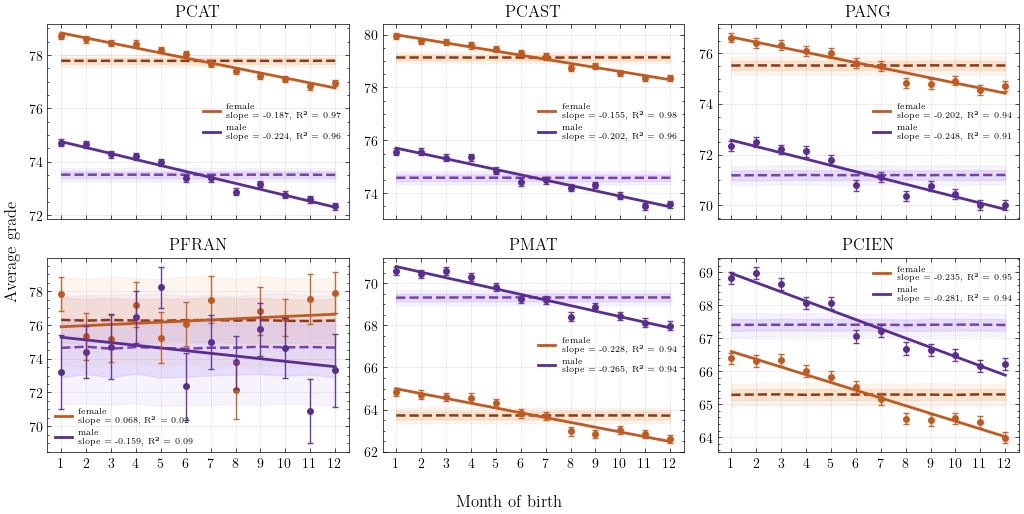

In [46]:
plt.style.use("birthmonth.mplstyle")

#--------------------------
#   SECONDARY – MULTIPLOT BY GENDER
#--------------------------

os.makedirs(birth_dir_gender_secondary, exist_ok=True)

# SECONDARY MAIN SUBJECTS (PCIEN for science)
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

n_subj = len(subjects_S)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True,    # same month axis
    sharey=False    # each subject chooses its own y-range
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_S):
    for gen in genders_S:
        key = (subj, gen)
        if key not in secondary_summaries_gender:
            continue  # no data for this subject+gender

        summary_S = secondary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_S['gender'].iloc[0]

        months     = summary_S['month'].values
        real_mean  = summary_S['real_mean'].values
        real_std   = summary_S['real_std'].values
        real_n     = summary_S['real_n'].values
        band_mean  = summary_S['null_mean'].values
        band_p16   = summary_S['band_p16'].values
        band_p84   = summary_S['band_p84'].values
        band_p2_5  = summary_S['band_p2_5'].values
        band_p97_5 = summary_S['band_p97_5'].values

        # Colors from gender palette (SECONDARY)
        band_color  = palette_gender['secondary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['secondary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['secondary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35
        )

        # Thermalized mean line (null mean) for this gender
        ax.plot(
            months, band_mean,
            linestyle='--',
            linewidth=1.8,
            color=mean_color,
            marker=None,
            # label=f'{gender_key} null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            # label=f'{gender_key} real mean'
        )

        # SEM from SD and n
        real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # Linear regression on real means, with slope and R^2 in legend text
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months
            r2 = r**2

            trend_label = f'{gender_key}\n slope = {slope:.3f}, R² = {r2:.2f}'

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=trend_label
            )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

    # One legend per subject (if something was plotted)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=6, loc='best')

# Hide unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

# Remove minor x ticks
for ax in fig.axes:
    ax.tick_params(axis='x', which='minor', length=0)

fig.tight_layout()
fig.savefig(
    os.path.join(birth_dir_gender_secondary, "secondary_all_subjects_by_gender_multiplot.png"),
    dpi=600,
    bbox_inches='tight'
)
plt.show()


## 3. Primary and secondary comparison with zscore

### Z score

In [ ]:
plt.style.use("birthmonth.mplstyle")

cmap_icefire = sns.color_palette("coolwarm", as_cmap=True)

os.makedirs(birth_dir_gender, exist_ok=True)

def plot_summary_heatmaps_by_gender(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_gender_all or df_stats_secondary_gender_all
              must contain:
              subject, month, gender, z_score, real_mean, null_mean

    For each gender:
      Heatmap colors = Z-score (distance from null in sigmas).
      Cell annotations = grade difference (real_mean - null_mean), in points.
    """

    # Desired subject order, depending on level_label
    subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
    subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

    # Loop over each gender present in this dataset
    for gender_key in sorted(df_stats['gender'].dropna().unique()):
        df = df_stats[df_stats['gender'] == gender_key].copy()
        if df.empty:
            continue

        # Ensure month is numeric and sorted
        df['month'] = pd.to_numeric(df['month'], errors='coerce')
        df = df.dropna(subset=['month'])

        # Sorted unique months
        months_sorted = sorted(df['month'].unique())

        # Subject order per level
        if level_label.lower().startswith("prim"):
            subject_order = subjects_P
        elif level_label.lower().startswith("sec"):
            subject_order = subjects_S
        else:
            subject_order = df['subject'].unique().tolist()

        # --- compute grade difference relative to null ("noise area") ---
        # delta_grade = real_mean - null_mean, in points
        df['delta_grade'] = df['real_mean'] - df['null_mean']

        # Pivot for colors: Z-scores
        z_pivot = (
            df.pivot_table(index='subject', columns='month', values='z_score')
              .reindex(index=subject_order)      # enforce subject order
              .reindex(columns=months_sorted)    # enforce month order
        )

        # Pivot for annotations: grade differences
        delta_pivot = (
            df.pivot_table(index='subject', columns='month', values='delta_grade')
              .reindex(index=subject_order)
              .reindex(columns=months_sorted)
        )

        # --- Z-score heatmap with grade-diff annotations ---
        fig, ax = plt.subplots(figsize=(6, 3.5))

        sns.heatmap(
            z_pivot,
            ax=ax,
            cmap=cmap_icefire,      # color encodes how many sigmas from null
            center=0,
            annot=True,      
            fmt='.2f',
            vmin=-25,
            vmax=25,
            cbar_kws={'label': 'Z-score (distance from null)'},
            annot_kws={'fontsize': 8}
        )

        # Remove tick lines but keep labels
        ax.tick_params(axis='both', which='both', length=0)

        ax.set_title(
            f'{level_label} – Effect of birth month on grades ({gender_key})\n'
            '(color = Z-score, number = grade difference in points)'
        )
        ax.set_ylabel('Subject')
        ax.set_xlabel('Month of birth')

        # Force x tick labels to be 1, 2, 3, ...
        month_labels = [str(int(m)) for m in months_sorted]
        ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells
        ax.set_xticklabels(month_labels, rotation=0)

        fig.tight_layout()

        filename = f"3.{filename_prefix}_{gender_key}_zscore_heatmap.png"
        fig.savefig(os.path.join(birth_dir_gender, filename), dpi=900, bbox_inches='tight')
        plt.show()


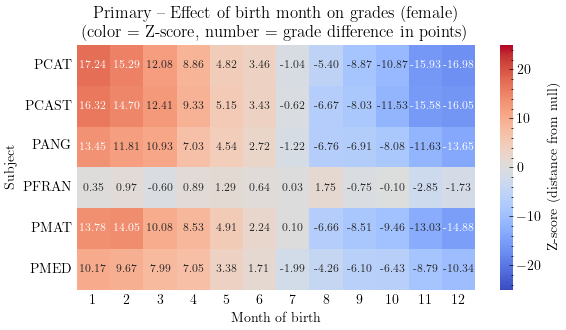

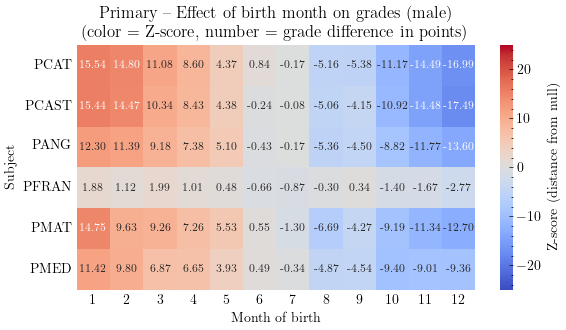

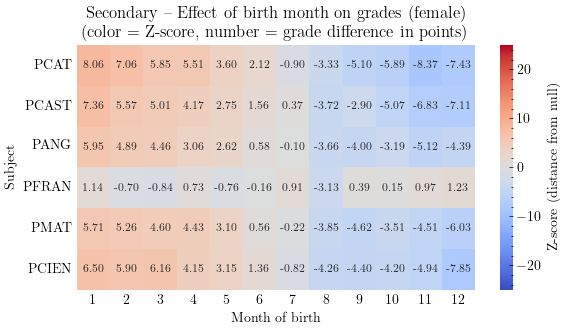

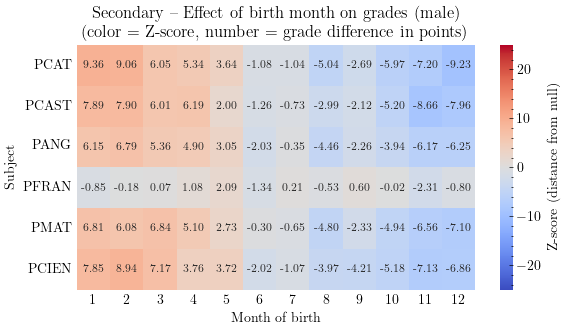

In [48]:
plot_summary_heatmaps_by_gender(df_stats_primary_gender_all,  'Primary',   'primary_gender')
plot_summary_heatmaps_by_gender(df_stats_secondary_gender_all, 'Secondary', 'secondary_gender')


### In which subjects and months does Secondary improve more or less than Primary relative to noise?

**We can see that on the area between the real points and the noise region. Does it increase or decrease?**

Now, we compute $area_{level, subject} = \sum_{m=1}^{12} | real\_ mean(m) - null\_ mean(m)| $

In [49]:
plt.style.use("birthmonth.mplstyle")

os.makedirs(birth_dir_gender, exist_ok=True)

# ============================
# PRIMARY: area by subject and gender
# ============================
subject_order_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']

dfPg = df_stats_primary_gender_all.copy()
dfPg['month'] = pd.to_numeric(dfPg['month'], errors='coerce')
dfPg = dfPg.dropna(subset=['month'])

dfPg['delta_grade'] = dfPg['real_mean'] - dfPg['null_mean']

area_P_gender = (
    dfPg.groupby(['subject', 'gender'])['delta_grade']
        .apply(lambda s: np.nansum(np.abs(s.values)))
        .unstack('gender')
        .reindex(index=subject_order_P)
)

net_P_gender = (
    dfPg.groupby(['subject', 'gender'])['delta_grade']
        .apply(lambda s: np.nansum(s.values))
        .unstack('gender')
        .reindex(index=subject_order_P)
)

# ============================
# SECONDARY: area by subject and gender
# ============================
subject_order_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

dfSg = df_stats_secondary_gender_all.copy()
dfSg['month'] = pd.to_numeric(dfSg['month'], errors='coerce')
dfSg = dfSg.dropna(subset=['month'])

dfSg['delta_grade'] = dfSg['real_mean'] - dfSg['null_mean']

area_S_gender = (
    dfSg.groupby(['subject', 'gender'])['delta_grade']
        .apply(lambda s: np.nansum(np.abs(s.values)))
        .unstack('gender')
        .reindex(index=subject_order_S)
)

net_S_gender = (
    dfSg.groupby(['subject', 'gender'])['delta_grade']
        .apply(lambda s: np.nansum(s.values))
        .unstack('gender')
        .reindex(index=subject_order_S)
)


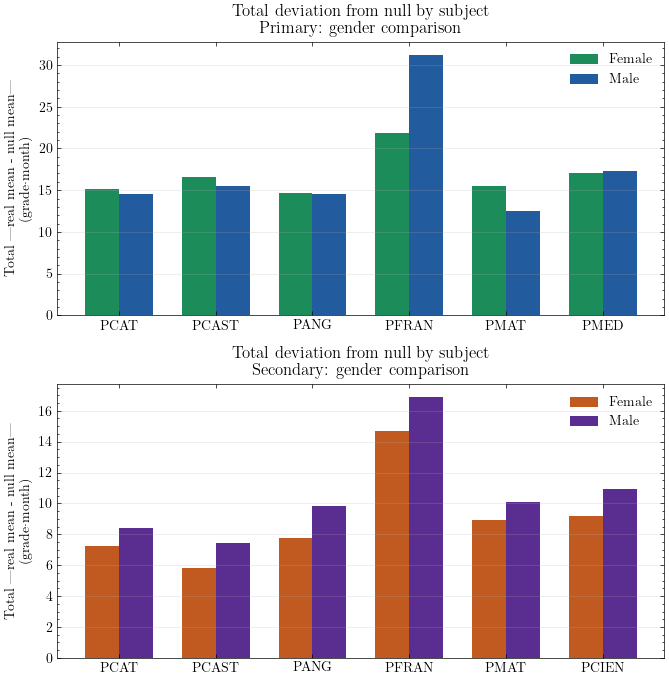

In [50]:
# Choose the order of gender columns as they appear in area_*_gender
gender_cols_P = list(area_P_gender.columns)  # e.g. ['male', 'female']
g1P, g2P = gender_cols_P[0], gender_cols_P[1]

gender_cols_S = list(area_S_gender.columns)
g1S, g2S = gender_cols_S[0], gender_cols_S[1]

xP = np.arange(len(subject_order_P))
xS = np.arange(len(subject_order_S))
width = 0.35

fig, (axP, axS) = plt.subplots(
    2, 1,
    figsize=(7, 7),
    sharex=False
)

# ---------- Primary ----------
axP.bar(
    xP - width/2,
    area_P_gender[g1P].values,
    width,
    label=g1P.capitalize(),
    color=palette_gender['primary'][g1P]['points']
)
axP.bar(
    xP + width/2,
    area_P_gender[g2P].values,
    width,
    label=g2P.capitalize(),
    color=palette_gender['primary'][g2P]['points']
)

axP.set_xticks(xP)
axP.set_xticklabels(subject_order_P)
axP.set_ylabel('Total |real mean - null mean|\n(grade·month)')
axP.set_title('Total deviation from null by subject\nPrimary: gender comparison')
axP.legend()
axP.grid(axis='y', alpha=0.3)

# ---------- Secondary ----------
axS.bar(
    xS - width/2,
    area_S_gender[g1S].values,
    width,
    label=g1S.capitalize(),
    color=palette_gender['secondary'][g1S]['points']
)
axS.bar(
    xS + width/2,
    area_S_gender[g2S].values,
    width,
    label=g2S.capitalize(),
    color=palette_gender['secondary'][g2S]['points']
)

axS.set_xticks(xS)
axS.set_xticklabels(subject_order_S)
axS.set_ylabel('Total |real mean - null mean|\n(grade·month)')
axS.set_title('Total deviation from null by subject\nSecondary: gender comparison')
axS.legend()
axS.grid(axis='y', alpha=0.3)

fig.tight_layout()
for ax_ in fig.axes:
    ax_.tick_params(axis='x', which='minor', length=0)

fig.savefig(
    os.path.join(birth_dir_gender, "4.area_primary_secondary_gender_by_subject.png"),
    dpi=900,
    bbox_inches='tight'
)
plt.show()


/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2575000942.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2575000942.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2575000942.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_64746/2575000942.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


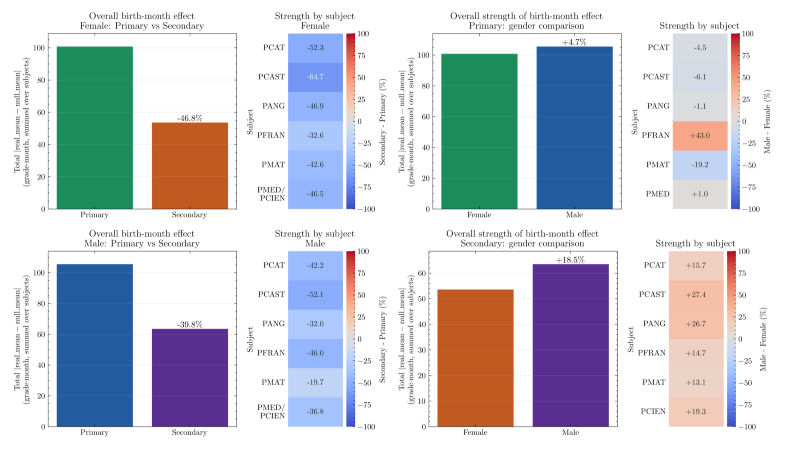

In [51]:
mpl.rcParams['text.usetex'] = True
plt.style.use("birthmonth.mplstyle")

os.makedirs(birth_dir_gender, exist_ok=True)

subject_order_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
subject_order_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
cmap = sns.color_palette("coolwarm", as_cmap=True)

# -----------------------------
# Helpers
# -----------------------------
def make_level_vs_level_plot(g, area_P_gender, area_S_gender, palette_gender, out_path):
    """Primary vs Secondary for fixed gender g (use PMED/\\nPCIEN label)."""
    # align subjects
    area_P_g = area_P_gender[g].reindex(subject_order_P)
    area_S_g = area_S_gender[g].reindex(subject_order_S)

    # rename only for this P vs S case
    area_P_g = area_P_g.rename(index={'PMED': 'PMED/\nPCIEN'})
    area_S_g = area_S_g.rename(index={'PCIEN': 'PMED/\nPCIEN'}).reindex(area_P_g.index)

    total_P = np.nansum(area_P_g.values)
    total_S = np.nansum(area_S_g.values)
    diff_pct = 100 * (total_S - total_P) / total_P

    fig = plt.figure(figsize=(7, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.2, 0.8], wspace=0.4)

    ax_bar = fig.add_subplot(gs[0, 0])
    ax_col = fig.add_subplot(gs[0, 1])

    levels = ['Primary', 'Secondary']
    totals = [total_P, total_S]

    bars = ax_bar.bar(
        levels, totals,
        color=[palette_gender['primary'][g]['points'],
               palette_gender['secondary'][g]['points']]
    )

    ymax = max(totals) * 1.08
    ax_bar.set_ylim(0, ymax)

    ax_bar.set_ylabel(
        r'Total $\left| \mathrm{real\_mean} - \mathrm{null\_mean} \right|$'
        '\n(grade·month, summed over subjects)'
    )
    ax_bar.set_title(
        rf'Overall birth-month effect'
        f'\n{g.capitalize()}: Primary vs Secondary'
    )
    ax_bar.grid(axis='y', alpha=0.3)

    bar_S = bars[1]
    x_S = bar_S.get_x() + bar_S.get_width() / 2
    y_S = bar_S.get_height()

    ax_bar.text(
        x_S, y_S,
        f'{diff_pct:+.1f}\\%',
        ha='center', va='bottom',
        fontsize=11
    )

    ax_bar.tick_params(axis='x', which='minor', length=0)

    # per-subject %
    area_diff = area_S_g - area_P_g
    area_pct = 100 * area_diff / area_P_g
    df_pct = area_pct.to_frame(name='% change')

    sns.heatmap(
        df_pct,
        ax=ax_col,
        cmap=cmap,
        center=0,
        vmin=-100,
        vmax=100,
        annot=True,
        fmt='+.1f',
        cbar_kws={'label': 'Secondary - Primary (\\%)'}
    )

    ax_col.set_xlabel('')
    ax_col.set_ylabel('Subject')
    ax_col.tick_params(axis='both', which='both', length=0)
    ax_col.set_title(f'Strength by subject\n{g.capitalize()}')

    # horizontal subject labels
    for lab in ax_col.get_yticklabels():
        lab.set_rotation(0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=900, bbox_inches='tight')
    plt.close(fig)


def make_gender_vs_gender_plot(level_label, area_gender, palette_level, out_path, subject_order):
    """Female vs male within a level (Primary or Secondary).
       Here KEEP PMED or PCIEN as-is."""
    genders = list(area_gender.columns)
    g1, g2 = genders[0], genders[1]

    # keep original index (PMED for primary, PCIEN for secondary)
    area_level = area_gender.copy()
    subject_order_used = subject_order  # no renaming here

    total_g1 = np.nansum(area_level[g1].values)
    total_g2 = np.nansum(area_level[g2].values)
    diff_pct = 100 * (total_g2 - total_g1) / total_g1

    fig = plt.figure(figsize=(7, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.2, 0.8], wspace=0.4)

    ax_bar = fig.add_subplot(gs[0, 0])
    ax_col = fig.add_subplot(gs[0, 1])

    levels = [g1.capitalize(), g2.capitalize()]
    totals = [total_g1, total_g2]

    bars = ax_bar.bar(
        levels, totals,
        color=[palette_level[g1]['points'],
               palette_level[g2]['points']]
    )

    ymax = max(totals) * 1.08
    ax_bar.set_ylim(0, ymax)

    ax_bar.set_ylabel(
        r'Total $\left| \mathrm{real\_mean} - \mathrm{null\_mean} \right|$'
        '\n(grade·month, summed over subjects)'
    )
    ax_bar.set_title(
        rf'Overall strength of birth-month effect'
        f'\n{level_label}: gender comparison'
    )
    ax_bar.grid(axis='y', alpha=0.3)

    bar_g2 = bars[1]
    x_g2 = bar_g2.get_x() + bar_g2.get_width() / 2
    y_g2 = bar_g2.get_height()

    ax_bar.text(
        x_g2, y_g2,
        f'{diff_pct:+.1f}\\%',
        ha='center', va='bottom',
        fontsize=11
    )

    ax_bar.tick_params(axis='x', which='minor', length=0)

    # per-subject %
    area_diff = area_level[g2] - area_level[g1]
    area_pct = 100 * area_diff / area_level[g1]
    df_pct = area_pct.reindex(subject_order_used).to_frame(name='% change')

    sns.heatmap(
        df_pct,
        ax=ax_col,
        cmap=cmap,
        center=0,
        vmin=-100,
        vmax=100,
        annot=True,
        fmt='+.1f',
        cbar_kws={'label': f'{g2.capitalize()} - {g1.capitalize()} (\\%)'}
    )

    ax_col.set_xlabel('')
    ax_col.set_ylabel('Subject')
    ax_col.tick_params(axis='both', which='both', length=0)
    ax_col.set_title('Strength by subject')

    for lab in ax_col.get_yticklabels():
        lab.set_rotation(0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=900, bbox_inches='tight')
    plt.close(fig)


def make_composite_image(path_female_ps, path_male_ps,
                         path_primary_gender, path_secondary_gender,
                         out_path, gap=90):
    """Join four PNGs with margins and show in cell."""
    img1 = Image.open(path_female_ps)
    img2 = Image.open(path_male_ps)
    img3 = Image.open(path_primary_gender)
    img4 = Image.open(path_secondary_gender)

    w, h = img1.size

    W = 2 * w + 3 * gap
    H = 2 * h + 3 * gap

    combo = Image.new("RGB", (W, H), "white")

    # order: P-S female | Primary gender
    #        P-S male   | Secondary gender
    combo.paste(img1, (gap, gap))
    combo.paste(img3, (gap + w + gap, gap))
    combo.paste(img2, (gap, gap + h + gap))
    combo.paste(img4, (gap + w + gap, gap + h + gap))

    combo.save(out_path, dpi=(900, 900))

    plt.figure(figsize=(10, 8))
    plt.imshow(combo)
    plt.axis('off')
    plt.show()

# -----------------------------
# Generate four plots
# -----------------------------
path1 = os.path.join(birth_dir_gender, "4.area_female_P_vs_S.png")
make_level_vs_level_plot('female', area_P_gender, area_S_gender,
                         palette_gender, path1)

path2 = os.path.join(birth_dir_gender, "4.area_male_P_vs_S.png")
make_level_vs_level_plot('male', area_P_gender, area_S_gender,
                         palette_gender, path2)

path3 = os.path.join(birth_dir_gender, "4.area_primary_gender.png")
make_gender_vs_gender_plot('Primary', area_P_gender,
                           palette_gender['primary'], path3, subject_order_P)

path4 = os.path.join(birth_dir_gender, "4.area_secondary_gender.png")
make_gender_vs_gender_plot('Secondary', area_S_gender,
                           palette_gender['secondary'], path4, subject_order_S)

# -----------------------------
# Composite image
# -----------------------------
combo_path = os.path.join(birth_dir_gender, "4.area_all_relative_comparisons.png")
make_composite_image(path1, path2, path3, path4, combo_path, gap=90)


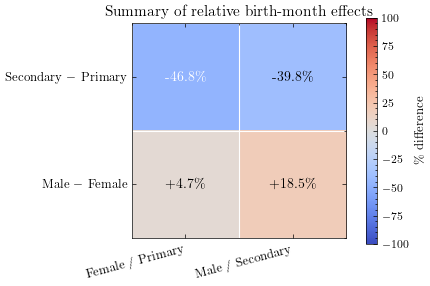

In [52]:
mpl.rcParams['text.usetex'] = True
plt.style.use("birthmonth.mplstyle")

summary_dir = birth_dir_gender
os.makedirs(summary_dir, exist_ok=True)

# Data (%)
# Row 0: Secondary - Primary (female, male)
# Row 1: Male - Female (primary, secondary)
data = np.array([
    [-46.8, -39.8],
    [ +4.7, +18.5]
])

row_labels = ["Secondary $-$ Primary", "Male $-$ Female"]
col_labels = ["Female / Primary", "Male / Secondary"]

vmin, vmax = -100, 100

fig, ax = plt.subplots(figsize=(4.5, 4.0))

im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='equal')

# Ticks / labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_xticklabels(col_labels, fontsize=9, rotation=15, ha='right')
ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels, fontsize=9)

# Grid lines
ax.set_xticks(np.arange(-0.5, len(col_labels), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(row_labels), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.8)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate values
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        color = "white" if abs(val) > 40 else "black"
        ax.text(j, i, f"{val:+.1f}\\%", ha="center", va="center",
                fontsize=10, color=color)

ax.set_title("Summary of relative birth-month effects", fontsize=11)

# Single shared colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.08)
cbar.set_label("\\% difference", fontsize=9)
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()

out_path = os.path.join(summary_dir, "4.summary_matrix_overall_effects_square.png")
fig.savefig(out_path, dpi=900, bbox_inches="tight")
plt.show()


# End of the notebook. See `BirthMonth.ipynb` for more